In [28]:
### IMPORT AND CONFIGURATION/UTILITIES FUNCTION
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True, attn_implementation="eager")

def get_tokens_prob(x, embeddings, k=5):
    # Compute the similarity between the token and all the tokens in the vocabulary, then applies softmax
    prob = torch.softmax(torch.matmul(x, embeddings.T), dim=-1)

    # Get the top k tokens
    top = torch.topk(prob, k=k)
    idxs = top.indices
    tokens = [tokenizer.decode(idx) for idx in idxs]
    return top.values, idxs, tokens

print(torch.__config__.show())
print(torch.__version__)

PyTorch built with:
  - GCC 13.3
  - C++ Version: 201703
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BUILD_TYPE=Release, COMMIT_SHA=3443627e078deb813ae37f7182d41a802bd05ac4, CXX_COMPILER=/usr/bin/c++, CXX_FLAGS=-O3 -march=native -mfma -mavx -mavx2 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_FBGEMM -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -O2 -fPIC -DC10_NODEPRECATED -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-unknown-pragmas -Wno-unused-parameter -Wno-strict-overflow -Wno-strict-aliasing -Wno-stringop-overflow -Wsuggest-override -Wno-psabi -Wno-error=old-style-cast -fdiagnostics-color=always -faligned-n

## Applying MaxEnt to explore the inner working of GPT2 

Let $\vec e_1, \vec e_2, \dots, \vec e_{n+1}$ be the tokens in the input prompt. We'd like to determine:
$$
p(\vec x | \vec e_1, \vec e_2, \dots, \vec e_n)
$$
which is essentially what the transformer computes after $12$ repetitions of the ATTN+FFNN mechanism. In principle, since the action of the transformer (_the dynamical rule_) is known, one could potentially figure out exactly the resulting pdf in the vocabulary space. This is however analytically infeasible, since the transformer is made of several non linear layers (FFNN) and the dynamics is allegedely extremely complicated. Thus, analoguosly to what we do in stat mech, we hope our system is ergodic and try to build a statistical description on top of the whole embedding space.

 In particular, we resort to the __MaxEnt principle__ to compute (analytically or not) the final conditioned pdf. Note that we do have the "correct" pdf $p(\vec x | \vec e_1, \vec e_2, \dots, \vec e_n)$ and the most probable token $e_{n+1}$. We just want to see whether, upon applying MaxEnt with the right constraints, we can obtain something similar to the distribution computed by the transformer

 ### Bolztmann-like approach
 The Shannon entropy functional $S$ reads:

$$
S[p] = -k \int d^D x \> p(\vec x) \ln p(\vec x) 
$$
the first constraint is, obviously, the normalization $ \int d^D x \> p(\vec x) = 1 $  (_over what? For now, I've normalized everything, so on the hypercube_)

In this first paragraph, we apply the following constraint:
$$
\langle \vec x \rangle = \vec{e}_{n+1}
$$
because we do have the "right" next token (again, we don't want to perform prediction here with the maxEnt. We just wish to see if the resulting pdf has some similarities with the one suggested by the maximization of $S$).

This leads to an analytic form for $p(\vec x | \vec e_1, \vec e_2, \dots, \vec e_n)$:
$$
p(\vec x | \vec e_1, \vec e_2, \dots, \vec e_n) = p(\vec x) = \frac{1}{Z} \exp(\vec \mu \cdot \vec x)
$$
with $Z =\prod_{i=1}^{D} \frac{2 sinh(\mu_i)}{\mu_i}$ and the vector $\mu$ (the lagrange multiplier) is such that:
$$
\vec e_{n+1} = -\frac{1}{\vec\mu} + \frac{1}{\tanh(\vec\mu)} \Longleftrightarrow \vec\mu = f(\vec e_{n+1})
$$

Practically speaking, we have built a pdf Boltzmann-like where the expected value has to be the correct next token and the mode (the vector in the embedding space that maximizes the probability) is precisely $\vec \mu$. Let's see what $\vec \mu$ is

In [4]:
# This is a multipurpose function that can be used to extract the probability density function of the next token and will be useful later.
def GPT2extractPDFLastToken(prompt, lengthPrediction=5):
    """
    This function takes a prompt masking the last word and returns the probability density function as computed by GPT 2 of what was the masked token.
    Additionally, it returns the attention vector and the embedding matrix of the masked sequence of tokens, if needed.
    :param prompt: The input prompt
    :return: The probability density function of the next token
    """
    prompt = ' '.join(prompt.split()[:-1])
    inputs = tokenizer(prompt, return_tensors="pt")
    n = len(inputs["input_ids"][0]) 

    with torch.no_grad():
        # run the transfomer inference
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states
        # get the hidden states (i.e. matrices of the last layer)
    layers = hidden_states[1:]

    # the next token is the last one in the last layer
    nextToken = (layers[-1][0])[-1]
    # project it into the vocabulary space and build a pdf on top of it using softmax
    prob, idxs, tokens = get_tokens_prob(nextToken, model.wte.weight.data,lengthPrediction)
    return prob, idxs, tokens

In [5]:
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo Galilei"
prob, idxs, tokens = GPT2extractPDFLastToken(prompt)
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

 -> logp = 0.28: [' Galile'], idx = 32422
 -> logp = 2.29: ['.'], idx = 13
 -> logp = 3.12: [' and'], idx = 290
 -> logp = 3.55: [','], idx = 11
 -> logp = 5.17: ['."'], idx = 526


In [8]:
#This is the function we want to solve
def f(x,k):
    return 1 / np.tanh(x) - 1 / x - k

# We need to constraint the mean value of the distribution to be equal to the expected value of the token
tokenExpected = model.wte.weight.data[idxs[0]]      # extracted from above

# Solve it component by component
mu = torch.tensor(np.zeros( model.wte.weight.data.shape[1]), dtype=torch.float32)

for i,d in enumerate(tokenExpected):
    xi = d.item()
    mu_i = fsolve(f, 1, args=(xi))
    mu[i] = (mu_i.item())
mu = mu / torch.norm(mu)  # Normalize the vector? Does it make sense?
print(f"mu = {torch.norm(mu)}")
print(f"Succesfully computed mu vector.")
print("It represents the direction of maximum probability; projecting mu over the vocabolary we get: \n")
# mu should be the direction of maximum probability (mode). At what does it point to?
prob, idxs, tokens = get_tokens_prob(mu, model.wte.weight.data, 8)
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

print("\nAs expected, it points practically with certainty to the right expected token")

mu = 0.9999999403953552
Succesfully computed mu vector.
It represents the direction of maximum probability; projecting mu over the vocabolary we get: 

 -> logp = 7.14: [' Galile'], idx = 32422
 -> logp = 9.71: [' Canaver'], idx = 46858
 -> logp = 9.83: ['Palest'], idx = 32570
 -> logp = 9.84: [' Galileo'], idx = 45860
 -> logp = 9.86: [' Presbyter'], idx = 40507
 -> logp = 9.87: [' Palest'], idx = 5480
 -> logp = 9.90: [' Jude'], idx = 30044
 -> logp = 9.91: [' horizont'], idx = 13736

As expected, it points practically with certainty to the right expected token


This is a boring result. We did get the right token but this was, of course, by no surprise since we cooked that information into the pdf. In fact, the other tokens suggested by the Boltzmann model were probably related to the word "Galilea" (Palest, Jude, Canaver). Since we didn't used the previous token, we lost all the context contained by the whole sequence of the prompt

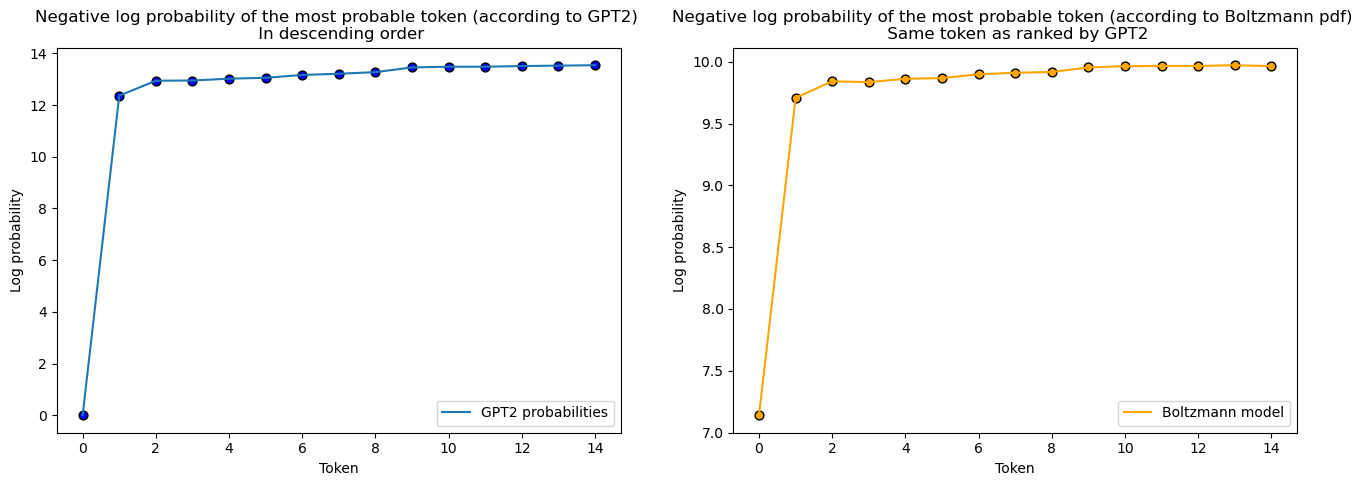

In [5]:
lengthQueue = 15
prob, idxs, tokens = get_tokens_prob(embeddings[idxs[0]]  , lengthQueue)

def logprobBoltzmann(x):
    unnorm = np.dot(x, mu)
    logterms = np.log( 2 * np.sinh(mu.numpy()) /  mu.numpy() )
    logZ = np.sum(logterms)
    logZdiscrete = np.sum(np.exp(np.dot(embeddings, mu)))
    logZdiscrete = np.log(logZdiscrete)
    return unnorm - logZdiscrete

probBolztmann = np.zeros(lengthQueue)   
for k,tkn in enumerate(embeddings[idxs]):
    #print(logprobBoltzmann(tkn.numpy()), -torch.log(prob[k]).item(), tokens[k])
    probBolztmann[k] = logprobBoltzmann(tkn.numpy())

fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[1].plot(-probBolztmann, label="Boltzmann model", c = "orange")
ax[1].scatter(range(len(probBolztmann)), -probBolztmann, color="orange", edgecolor="black", s=40)
ax[0].plot(-torch.log(prob).numpy(), label="GPT2 probabilities")
ax[0].scatter(range(len(prob)), -torch.log(prob).numpy(), color="blue", edgecolor="black", s=40)
ax[0].set_title("Negative log probability of the most probable token (according to GPT2) \n In descending order")
ax[0].set_xlabel("Token")
ax[0].set_ylabel("Log probability")
ax[0].legend()
ax[1].set_xlabel("Token")
ax[1].set_ylabel("Log probability")
ax[1].legend()
ax[1].set_title("Negative log probability of the most probable token (according to Boltzmann pdf) \n Same token as ranked by GPT2")
plt.show()





Nota che per come funziona il transformer, la distribuzione finale deve essere alla Bolztmann -> tutto ciò per dire che è compatibile con un discorso maxent e quindi ci motiva quanto meno a procedere


## Using the attention matrix - continuous approach

The previous approach was clearly extremely simple and trivial, lacking precious information that we have on the resulting pdf (in fact, we didn't use the previous tokens $\{e_i\}$). Let us think of a new constraint. Since the dot product in the embedding space (upon normalization) is somehow related to the similarities between tokens, we may wish to constrain:
$$ 
\langle \vec x \cdot \vec e_i \rangle = something, \>\> \forall \vec e_i
$$
Since the transfomer provides us with attention matrices, why don't use those quantities to constrain our entropy. In particular, if $\hat A$ is the $(n+1) \times (n+1)$ attention matrix at the end of 

N.B. Again, this is kinda stupid, since in order to compute the attention matrix we need to know before-hand the next token, thus making this approach pretty useless. We can rephrase it in this way: given that someone from above gifts us with the correlation that the next token has with the previous ones but not the token itself, then we can build a MaxEnt model from that scarce information. A posteriori, we can see whether GPT's distribution is similar to the one produced with this method

In [19]:
from scipy.optimize import least_squares

def getEA(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    n = len(inputs["input_ids"][0]) 

    with torch.no_grad():
        outputs = model(**inputs)
    attentions = outputs.attentions

    lastStepAttentionMatrices = attentions[0][0]
    vectorA = torch.tensor( np.zeros(n-1) )              # Not the last token (itself w/ itself)
    #iterate on the heads
    for head in range(12):
        attentionHead = lastStepAttentionMatrices[head]
        column = attentionHead[-1,:]   # last row
        column = column[:-1]           # remove the last element (autocorrelation)
        # renormalize
        column = column/(torch.sum(column))
        vectorA = (vectorA + column)
    # Normalization step
    vectorA = vectorA / 12
    #print("The vector A is: ", vectorA)

    embeddings = model.wte.weight.data
    T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
    E = torch.matmul(T,embeddings)
    E = E[:-1,:]                                         # I don't want the last (masked) token   
    return vectorA, E

# f function (to improve stability, Taylor expansion around 0)
def f(z, tol = 0.001):
    z = np.asarray(z) 
    result = np.empty_like(z, dtype=float)
    # when z is small, we use a Taylor expansion (to avoid numerical instability)
    z_small = z[np.abs(z) < tol]
    result[np.abs(z) < tol] = (-1/3)*z_small + (2/45)*z_small**3 - (17/945)*z_small**5
    # when z is big, we use the original function
    z_big = z[np.abs(z) > tol]
    result[np.abs(z) > tol] = - 1 / np.tanh(z_big) + 1 / z_big
    return result

# This is the system we want to solve
def system(x, E, A):
    z = np.dot(E.T, x)     
    fz = f(z)        
    fz = fz.reshape(-1, 1)     
    v = E @ fz
    v = v.reshape(-1)      
    return v - A      

def solveMu(E, vectorA, amplificationAttention=1):
    x0 = np.random.random(len(vectorA))
    x0 = 0.1*x0 

    res = least_squares(
        system, x0,
        args=(E.numpy(), amplificationAttention * vectorA.numpy()),
        method="trf",       # trust-region reflective
        max_nfev=1000,      # max iterations
        xtol=1e-8,          # precision
        verbose=0
    )
    if not res.success:
        print(" least_squares non ha convergenza:", res.message)
    return res.x

def computeZ(a, V):
    Z = 0
    for token in V:
        dot_product = np.dot(token, a)
        exp_value = np.exp(dot_product)
        Z += exp_value
    #print("Z = ", Z ,"**********")
    return Z

def computeLogZ(a, V):
    s = torch.sum(a * V, axis=1)  # shape: (n,)
    a = torch.min(s)
    return -a + torch.log(torch.sum(torch.exp(-(s - a))))

def createPDFoverVocabulary(a, Z, lengthQueue = 10):
    """
    This function creates a probability density function over the vocabulary using the mu vector and the embeddings.
    :param mu: The mu vector
    :param V: The embeddings matrix
    :return: The probability density function over the vocabulary
    """
    embeddings = model.wte.weight.data
    logProb = np.zeros(len(embeddings))
    for i,tkn in enumerate(embeddings):
        dot_product = np.dot(tkn, a)
        logProb[i] = -dot_product + np.log(Z)
        
    sorted_indices = np.argsort(logProb)
    id_to_token = {v: k for k, v in tokenizer.encoder.items()}
    for j in range(lengthQueue):
        decoded_token = tokenizer.decode([sorted_indices[j]])
        print(f" -> -logP: { logProb[sorted_indices[j]]:.4f}, [{decoded_token}], idx = {sorted_indices[j]}")


def gpt2_tokens(text):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    input_ids = tokenizer.encode(text, add_special_tokens=False)
    tokens = [tokenizer.decode([token_id]) for token_id in input_ids]
    return tokens



In [27]:
# A bunch of test prompts
prompt = "--- - - - ---- - - - ----p''''' -"
prompt = "Mount Everest is the tallest mountain on Earth, located in the Himalayas on the border between Nepal and China"
prompt = "The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants. Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on"
prompt = "The american flag is white, red and blue. The flag has 13 stripes and 50 stars"
prompt = "The Great Wall of China is a series of fortifications built to protect ancient Chinese states from invasions. It stretches over 13,000 miles and is one of the most iconic structures in the world. The wall was built over several dynasties, with the earliest sections dating back to the 7th century BC"
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I made groundbreaking contributions not only to relativity but also to quantum mechanics, statistical mechanics, and cosmology. " \
"My famous equation, E=mc², has become one of the most well-known formulas in the world. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect, which helped establish quantum theory. " \
"Throughout my life, I advocated for civil rights, pacifism, and Zionism, and I was known for my humanitarian views. " \
"I spent my later years in the United States, working at the Institute for Advanced Study in Princeton. " \
"I was born in 1879 and died in 1955. My name is Albert Einstein"
prompt = "DNA, or deoxyribonucleic acid, is the molecule that carries genetic instructions in all living organisms. It is composed of four nucleotide bases: adenine, thymine, cytosine, and guanine. These bases form sequences that determine traits and biological functions. The structure of DNA is a double helix, with two strands winding around each other, held together by complementary base pairing—adenine pairs with thymine, and cytosine with guanine. This configuration ensures accurate replication during cell division. Mutations, or changes in the DNA sequence, can lead to variations in traits, some of which may result in genetic disorders or evolutionary advantages.DNA replication and transcription are essential processes that convert genetic information into proteins, which perform vital structural and functional roles in the body. Understanding DNA has revolutionized fields such as medicine, forensic science, and biotechnology, enabling breakthroughs like gene editing and personalized treatments"
prompt = "The american flag is white, red and blue"
prompt = "DNA, or deoxyribonucleic acid, is the molecule that carries genetic instructions in all living organisms. It is composed of four nucleotide bases: adenine, thymine, cytosine, and guanine. These bases form sequences that determine traits and biological functions"
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect." \
" I was born in 1879 and died in 1955. My name is Albert Einstein"
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo Galilei"
prompt = "The Mona Lisa is a world-famous painting by Leonardo da Vinci, created in the early 16th century. It is housed in the Louvre Museum in Paris and is known for its enigmatic expression and detailed background. The painting is considered a masterpiece of the Italian Renaissance"

prob, idxs, tokens = GPT2extractPDFLastToken(prompt, 10)
print(gpt2_tokens(prompt))
print("Masking the last token (\"" , ''.join(prompt.split()[-1]), "\"), GPT2 would have predicted:", sep = "")
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> -logP = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")


model.wte.weight.data = torch.nn.functional.normalize(model.wte.weight.data, p=2, dim = 1)
# Get the attention vector and the embedding matrix
vectorA, E = getEA(prompt)
# Let's solve for mu, now that we have the attention vector and the embedding matrix
amplificationAttention = 4
mu = solveMu(E, vectorA, amplificationAttention)
Z = computeZ(-E.T @ mu, model.wte.weight.data)
# given mu, we can compute the mean and the mode according to the maxent model
x_avg, x_mode = f(E.T @ mu), -E.T @ mu


print("\nA MaxEnt approach yields:")
print("For the mean value (MAXENT):")
prob, idxs, tokens = get_tokens_prob(torch.tensor(x_avg, dtype = torch.float), model.wte.weight.data, 5)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")

print("For the mode value (MAXENT):")
prob, idxs, tokens = get_tokens_prob(torch.tensor(x_mode, dtype = torch.float),  model.wte.weight.data, 5)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")

#print("\nMaxEnt would have predicted the following tokens:")
#createPDFoverVocabulary(-E.T @ mu, Z, 10)

['The', ' Mon', 'a', ' Lisa', ' is', ' a', ' world', '-', 'famous', ' painting', ' by', ' Leonardo', ' da', ' Vin', 'ci', ',', ' created', ' in', ' the', ' early', ' 16', 'th', ' century', '.', ' It', ' is', ' housed', ' in', ' the', ' Lou', 'vre', ' Museum', ' in', ' Paris', ' and', ' is', ' known', ' for', ' its', ' enigmatic', ' expression', ' and', ' detailed', ' background', '.', ' The', ' painting', ' is', ' considered', ' a', ' masterpiece', ' of', ' the', ' Italian', ' Renaissance']
Masking the last token ("Renaissance"), GPT2 would have predicted:
 -> -logP = 5.76: ['theless'], idx = 9603
 -> -logP = 5.90: ['soDeliveryDate'], idx = 39811
 -> -logP = 5.98: [' "$:/'], idx = 32047
 -> -logP = 5.98: ['SPONSORED'], idx = 37190
 -> -logP = 6.11: ['interstitial'], idx = 29446
 -> -logP = 6.29: ['entimes'], idx = 43598
 -> -logP = 6.43: [' ‎'], idx = 24398
 -> -logP = 6.43: ['inventoryQuantity'], idx = 39756
 -> -logP = 6.44: ['manship'], idx = 25428
 -> -logP = 6.45: [' ILCS'], idx =

/tmp/ipykernel_6693/568661031.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob, idxs, tokens = get_tokens_prob(torch.tensor(x_mode, dtype = torch.float),  model.wte.weight.data, 5)


## Discretization
Let us now discretize the whole thing

In [132]:
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model
from scipy.special import softmax
from scipy.optimize import minimize

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True, attn_implementation="eager")

def getEA(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    n = len(inputs["input_ids"][0]) 

    with torch.no_grad():
        outputs = model(**inputs)
    # extract the attentions matrices
    attentions = outputs.attentions
    
    chosenLayer = 0
    lastStepAttentionMatrices = attentions[chosenLayer][0]
    vectorA = torch.tensor( np.zeros(n-1) )              # Not the last token (itself w/ itself)
    #iterate on the heads
    for head in range(12):
        attentionHead = lastStepAttentionMatrices[head]
        column = attentionHead[-1,:]   # last row
        column = column[:-1]           # remove the last element (autocorrelation)
        column = column/(torch.sum(column))
        vectorA = (vectorA + column)
    # Normalization step
    vectorA = vectorA / 12
    #print("The vector A is: ", vectorA)

    T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
    E = torch.matmul(T,embeddings)
    #E = E / np.linalg.norm(E, axis=0, keepdims=True)     # Normalize again by row
    E = E[:-1,:]                                         # I don't want the last (masked) token   
    return vectorA, E

def loss(mu, Om, A):
    ZT_mu = torch.matmul(Om.T, mu) 
    s = torch.softmax(-ZT_mu, dim=0)  
    Zs = torch.matmul(Om, s)  
    return torch.sum((Zs - A)**2)

def solveMuDiscrete2(E, embeddings, A, lr=0.05, max_iter=1000, verbose=True):
    OMEGA = torch.matmul(E, embeddings.T)
    
    correctEinstein = embeddings[tokenizer.convert_tokens_to_ids(tokenizer.tokenize(" Galile"))].numpy()
    correctEinstein.shape = (768,)
    print(correctEinstein.shape, "should be (n,)")
    x = np.linalg.pinv(E.T) @ correctEinstein

    mu = torch.nn.Parameter(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    optimizer = torch.optim.Adam([mu], lr=lr)
    
    for i in range(max_iter):
        optimizer.zero_grad()
        L = loss(mu, OMEGA, A)
        L.backward()
        optimizer.step()

        if verbose and i % 50 == 0:
            #print(f"Iter {i}: loss = {L.item():.6f}")
            pass

    if verbose:
        print(f"Final loss: {L.item():.6f}")
        print(f"Optimal mu: {mu.detach()}")
        print("A should be: ", torch.matmul(OMEGA, torch.softmax(-torch.matmul(OMEGA.T, mu), dim=0)) )
        print("A as computed with the right mu:", torch.matmul(OMEGA, torch.softmax(-torch.matmul(OMEGA.T, torch.tensor(x)), dim=0)) )

    return mu.detach()

In [133]:
### TEST PANEL
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo Galilei"

vectorA, E = getEA(prompt)
#vectorA = vectorA * torch.mean(torch.norm(E, dim = 1))   # SI potrebbe fare questa roba qui


mu = solveMuDiscrete2(E, embeddings, vectorA)
print("A is: ", vectorA)

(768,) should be (n,)
Final loss: 156.775253
Optimal mu: tensor([ 2.8029,  1.5693,  0.8656,  0.4880,  1.4544,  1.4284,  1.9235,  0.3555,
         2.9166,  1.0807,  0.5696,  1.0092, -1.3021,  1.7459,  0.6763,  2.4579,
         2.6053,  0.3555,  0.5842,  3.2383,  0.3917,  2.6559,  0.3936,  0.4900,
         0.5696,  1.0092,  0.8125,  2.5209,  0.3555,  4.8606,  2.0147,  0.3936,
         1.3688,  0.3555,  5.3335,  0.9769,  0.5696,  1.8284,  1.8446,  0.5095,
         0.7014,  1.6791])
A should be:  tensor([1.8338, 2.6065, 1.5259, 2.6844, 2.9774, 1.8684, 1.7922, 1.2597, 2.1481,
        2.5474, 1.3402, 1.3531, 2.2867, 1.8526, 1.2978, 1.8259, 1.6653, 1.2597,
        1.0524, 2.0211, 1.4129, 2.1828, 1.1964, 3.2108, 1.3402, 1.3531, 1.7825,
        2.1459, 1.2597, 1.4823, 2.0977, 1.1964, 2.4987, 1.2597, 1.3840, 2.4014,
        1.3402, 2.1615, 1.8959, 1.5694, 2.9707, 3.1494], grad_fn=<MvBackward0>)
A as computed with the right mu: tensor([2.5193, 3.0843, 1.7930, 2.8499, 3.7782, 2.1867, 2.9676, 1.385

In [ ]:
# A bunch of test prompts
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo Galilei"
prompt = "DNA, or deoxyribonucleic acid, is the molecule that carries genetic instructions in all living organisms. It is composed of four nucleotide bases: adenine, thymine, cytosine, and guanine. These bases form sequences that determine traits and biological functions"
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect." \
" I was born in 1879 and died in 1955. My name is Albert Einstein"

# get the embedding matrix
embeddings = model.wte.weight.data
# Get the attention vector and the embedding matrix
vectorA, E = getEA(prompt)
## vectorA = vectorA * torch.mean(torch.norm(E, dim = 1))   # SI potrebbe fare questa roba qui

# Let's solve for mu, now that we have the attention vector and the embedding matrix
mu = solveMuDiscrete2(E.numpy(), embeddings.numpy(), vectorA.numpy()) 
mu = torch.tensor(mu, dtype=torch.float32) 

correctEinsten = np.load("nextToken.npy")
x = np.linalg.pinv(E.T) @ correctEinsten
mu = torch.tensor(x)
Z = computeZ(-torch.matmul(E.T, mu), embeddings)
print("logZ =", Z)

print("\nMaxEnt would have predicted the following tokens:")
createPDFoverVocabulary(-torch.matmul(E.T, mu), Z, 10)

print("For the mode value (MAXENT):")
prob, idxs, tokens = get_tokens_prob(torch.tensor(-torch.matmul(E.T, mu), dtype = torch.float), 5)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")

The embedding matrix E is of shape: torch.Size([53, 768])
The attention vector A is of shape: torch.Size([53])
Success: True
mu ottimo: [ 1.023381   -2.9592173  -5.206721   -2.0732296   2.5953646  -0.9638976
 -2.856685    2.278399   -1.2299044  -4.0165873  -2.4396253  -3.2346785
 -6.2767773  -1.3281077  -0.46446112  0.44732043 -0.17959857  0.27987838
  0.92262757 -0.48367685 -0.47447097 -2.2126894  -0.8918188   0.02618492
 -0.30484015 -1.2606374   3.0614607  -1.2606374   0.29027256 -4.7754555
 -0.46446112 -2.3145423  -0.17959857 -0.8918188  -3.2158034  -1.3152328
 -5.136659    0.92262757 -0.48367685 -0.47447097  0.9417038  -1.2606374
 -6.080223   -3.1928399  -3.5324836  -0.90797246 -1.2606374  -1.0050166
  0.92262757 -2.852927   -2.8601222   0.7233646  -0.6211818 ]
Errore finale: 1563.5901225896453
Correct mu: [ 0.5116905  -1.4796087  -2.6033604  -1.0366148   1.2976823  -0.4819488
 -1.4283425   1.1391995  -0.6149522  -2.0082936  -1.2198126  -1.6173393
 -3.1383886  -0.66405386 -0.232230

NameError: name 'computeZ' is not defined

The expected value is not that bad (comments)

Nota bene una cosa: qua stiamo ponendo solo $n$ condizioni, ma la distribuzione è su di uno spazio $ d > n $ dimensionale. Dunque stiamo dicendo che il valore medio \langle x \rangle non è completamente vincolato (come nel caso precedente), ne stiamo vincolando solo una parte ($n$ componenti, linearmente). Il resto fa maxEnt. Il fatto che qua il valore medio venga decente, almento secondo me, non è scontato (soprattutto se $n$ è molto più piccolo di $d$).

Sarebbe carino capire come migliora il modello aggiungendo vincoli, cioè aumentando la dimensione del prompt.

----
Now without guessing A



In [60]:
# To extract the weights and biases of the attention heads in GPT-2
def extractFromGPT2Weights(model, layer:int, head:int):
    layer = model.h[layer]
    W_qkv = layer.attn.c_attn.weight  
    d_model = model.config.n_embd  
    W_Q = W_qkv[:d_model, :d_model]     
    W_K = W_qkv[:d_model, d_model:2*d_model]
    W_V = W_qkv[:d_model, 2*d_model:]

    head_dim = d_model // model.config.n_head
    i = head  
    W_Q_i = W_Q[i * head_dim : (i + 1) * head_dim, :] 
    W_K_i = W_K[i * head_dim : (i + 1) * head_dim, :]
    W_V_i = W_V[i * head_dim : (i + 1) * head_dim, :]
    return W_Q_i.detach().numpy(), W_K_i.detach().numpy(), W_V_i.detach().numpy()

def extractFromGPT2Bias(model, layer:int, head:int):
    layer = model.h[layer]
    b_qkv = layer.attn.c_attn.bias  # torch.nn.Parameter
    d_model = model.config.n_embd  #. 768
    b_Q = b_qkv[:d_model]        # (768,)
    b_K = b_qkv[d_model:2*d_model]
    b_V = b_qkv[2*d_model:]
    
    head_dim = d_model // model.config.n_head
    i = head  # ad esempio, testa 5
    b_Q_i = b_Q[i * head_dim : (i + 1) * head_dim] 
    b_K_i = b_K[i * head_dim : (i + 1) * head_dim]
    b_V_i = b_V[i * head_dim : (i + 1) * head_dim]
    return b_Q_i.detach().numpy(), b_K_i.detach().numpy(), b_V_i.detach().numpy()

# This function computes the expected activation vector A for the given embedding matrix E, giving us an estimate for the correlations values
def computeExpectedA(E):
    nHeads = 12
    # This will be the best query that resonates with the given keys (old tokens)
    bestFitting = torch.tensor( np.zeros(E.shape[1]) , dtype=torch.float32)
    # we will essentially average over the heads ...
    for head in range(nHeads):
        WQ, WK, _ = extractFromGPT2Weights(model, layer = 0, head = head)
        bq, bk,_ = extractFromGPT2Bias(model, layer = 0, head = head)
        vectors = torch.tensor(np.zeros((E.shape[0],E.shape[1])), dtype=torch.float32)
        # and over the tokens !
        for i,e in enumerate(E):
            vectors[i] = torch.matmul(torch.tensor(WQ.T), torch.tensor(bk)) + torch.matmul(torch.matmul(torch.tensor(WK).T, torch.tensor(WQ)), e)
        # sum the vectors by row
        bestfittingHead = torch.sum(vectors, dim=0)
        # update the general vector
        bestFitting = bestFitting + bestfittingHead
    bestFitting = bestFitting / torch.mean(bestFitting)  # Normalize the vector?

    A = np.zeros(E.shape[0])   # The activation, i.e. the last row vector
    for head in range(nHeads):
        WQ, WK, _ = extractFromGPT2Weights(model, 0, head)
        bq, bk,_ = extractFromGPT2Bias(model, 0, head)
        J = np.matmul(WK.T, WQ) 
        vkq = np.matmul(WK.T , bq)
        localA = np.zeros(E.shape[0])
        for i, e in enumerate(E):
            localA[i] = ( np.matmul(e, np.matmul(J, bestFitting)) + np.matmul(vkq, e) )/8
        localA = torch.softmax(torch.tensor(localA), dim=0).numpy()  # Apply softmax to the local activation vector on the row
        A = A + localA
    A = A / nHeads  # Average over the heads
    return A

In [67]:
prompt = "--- - - - ---- - - - ----p''''' -"
prompt = "The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants. Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on"
prompt = "The Great Wall of China is a series of fortifications built to protect ancient Chinese states from invasions. It stretches over 13,000 miles and is one of the most iconic structures in the world. The wall was built over several dynasties, with the earliest sections dating back to the 7th century BC"
prompt = "DNA, or deoxyribonucleic acid, is the molecule that carries genetic instructions in all living organisms. It is composed of four nucleotide bases: adenine, thymine, cytosine, and guanine. These bases form sequences that determine traits and biological functions. The structure of DNA is a double helix, with two strands winding around each other, held together by complementary base pairing—adenine pairs with thymine, and cytosine with guanine. This configuration ensures accurate replication during cell division. Mutations, or changes in the DNA sequence, can lead to variations in traits, some of which may result in genetic disorders or evolutionary advantages.DNA replication and transcription are essential processes that convert genetic information into proteins, which perform vital structural and functional roles in the body. Understanding DNA has revolutionized fields such as medicine, forensic science, and biotechnology, enabling breakthroughs like gene editing and personalized treatments"
prompt = "The Mona Lisa is a world-famous painting by Leonardo da Vinci, created in the early 16th century. It is housed in the Louvre Museum in Paris and is known for its enigmatic expression and detailed background. The painting is considered a masterpiece of the Italian Renaissance."
prompt = "DNA, or deoxyribonucleic acid, is the molecule that carries genetic instructions in all living organisms. It is composed of four nucleotide bases: adenine, thymine, cytosine, and guanine. These bases form sequences that determine traits and biological functions."
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. " \
        "I was born in 1564 and died in 1642. My name is Galileo Galilei"
prompt = "Mount Everest is the tallest mountain on Earth, located in the Himalayas on the border between Nepal and China"
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect." \
" I was born in 1879 and died in 1955. My name is Albert Einstein"
prompt = "The american flag is white, red and blue. The flag has 13 stripes and 50 stars"
prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I made groundbreaking contributions not only to relativity but also to quantum mechanics, statistical mechanics, and cosmology. " \
"My famous equation, E=mc², has become one of the most well-known formulas in the world. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect, which helped establish quantum theory. " \
"Throughout my life, I advocated for civil rights, pacifism, and Zionism, and I was known for my humanitarian views. " \
"I spent my later years in the United States, working at the Institute for Advanced Study in Princeton. " \
"I was born in 1879 and died in 1955. My name is Albert Einstein"

prob, idxs, tokens = GPT2extractPDFLastToken(prompt, 10)
print("Masking the last token (\"" , ''.join(prompt.split()[-1]), "\"), GPT2 would have predicted:", sep = "")
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> -logP = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

prompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I made groundbreaking contributions not only to relativity but also to quantum mechanics, statistical mechanics, and cosmology. " \
"My famous equation, E=mc², has become one of the most well-known formulas in the world. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect, which helped establish quantum theory. " \
"Throughout my life, I advocated for civil rights, pacifism, and Zionism, and I was known for my humanitarian views. " \
"I spent my later years in the United States, working at the Institute for Advanced Study in Princeton. " \
"I was born in 1879 and died in 1955. My name is Albert"
inputs = tokenizer(prompt, return_tensors="pt")
T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
E = torch.matmul(T,embeddings)
E = E / np.linalg.norm(E, axis=1, keepdims=True)  
# Let's solve for mu, now that we have the attention vector and the embedding matrix
amplificationAttention = 1
vectorA, _ = getEA(prompt)
mu = solveMu(E, torch.tensor(computeExpectedA(E)), amplificationAttention)
Z = computeZ(-E.T @ mu, embeddings)
# given mu, we can compute the mean and the mode according to the maxent model
x_avg, x_mode = f(E.T @ mu), -E.T @ mu

""""
print("\nA MaxEnt approach yields:")
print("For the mean value (MAXENT):")
prob, idxs, tokens = get_tokens_prob(torch.tensor(x_avg, dtype = torch.float), 5)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")

print("For the mode value (MAXENT):")
prob, idxs, tokens = get_tokens_prob(torch.tensor(x_mode, dtype = torch.float), 5)
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")
"""
print("\nMaxEnt would have predicted the following tokens:")
createPDFoverVocabulary(-E.T @ mu, Z, 10)

Masking the last token ("Einstein"), GPT2 would have predicted:
 -> -logP = 0.96: [' Einstein'], idx = 24572
 -> -logP = 4.00: [' B'], idx = 347
 -> -logP = 4.07: [' E'], idx = 412
 -> -logP = 4.30: [' J'], idx = 449
 -> -logP = 4.37: [' H'], idx = 367
 -> -logP = 4.38: [' A'], idx = 317
 -> -logP = 4.47: [' S'], idx = 311
 -> -logP = 4.51: [' L'], idx = 406
 -> -logP = 4.55: ['.'], idx = 13
 -> -logP = 4.56: [' W'], idx = 370
tensor(1.0000, dtype=torch.float64)
tensor([0.0572, 0.0024, 0.0021, 0.0194, 0.0023, 0.0141, 0.0109, 0.0251, 0.0026,
        0.0062, 0.0031, 0.0027, 0.0060, 0.0024, 0.0018, 0.0051, 0.0019, 0.0119,
        0.0028, 0.0014, 0.0019, 0.0050, 0.0039, 0.0013, 0.0013, 0.0018, 0.0108,
        0.0019, 0.0016, 0.0017, 0.0038, 0.0034, 0.0022, 0.0053, 0.0033, 0.0023,
        0.0024, 0.0026, 0.0059, 0.0027, 0.0013, 0.0046, 0.0035, 0.0021, 0.0020,
        0.0015, 0.0026, 0.0025, 0.0020, 0.0017, 0.0016, 0.0011, 0.0014, 0.0018,
        0.0014, 0.0015, 0.0020, 0.0019, 0.0033, 0.001

Putting it all together...

In [13]:
initialPrompt = "I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. " \
"I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect." \
" I was born in 1879 and died in 1955. My name is Albert"

for t in range(10):
    print(f"\nIteration {t+1}:")
    inputs = tokenizer(initialPrompt, return_tensors="pt")
    T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
    E = torch.matmul(T,embeddings)
    E = E / np.linalg.norm(E, axis=1, keepdims=True)  
    # Let's solve for mu, now that we have the attention vector and the embedding matrix
    amplificationAttention = 1
    mu = solveMu(E, torch.tensor(computeExpectedA(E)), amplificationAttention)
    Z = computeZ(-E.T @ mu, embeddings)

    logProb = np.zeros(len(embeddings))
    for i,tkn in enumerate(embeddings):
        dot_product = np.dot(tkn, -E.T @ mu)
        logProb[i] = -dot_product + np.log(Z)
    sorted_indices = np.argsort(logProb)[:20]
    
    id_to_token = {v: k for k, v in tokenizer.encoder.items()}
    for j in range(10):
        decoded_token = tokenizer.decode([sorted_indices[j]])
        #print(f" -> -logP: { logProb[sorted_indices[j]]:.4f}, [{decoded_token}], idx = {sorted_indices[j]}")

    top_k = 10
    sorted_indices = np.argsort(logProb)[:top_k] 
    temperature = 1

    # Calcola probabilità con temperatura
    top_log_probs = torch.tensor(logProb[sorted_indices])
    adjusted_logits = -top_log_probs / temperature
    top_probs = torch.softmax(adjusted_logits, dim=0)
    sampled_relative_index = torch.multinomial(top_probs, num_samples=1).item()
    sampled_token_id = sorted_indices[sampled_relative_index]
    decoded_token = tokenizer.decode([sampled_token_id])

    print("Chosen token:", decoded_token)
    initialPrompt += decoded_token
print(initialPrompt)


Iteration 1:
Chosen token:  physicist

Iteration 2:
Chosen token:  an

Iteration 3:
Chosen token:  Wonders

Iteration 4:
Chosen token:  Math

Iteration 5:
Chosen token: a

Iteration 6:
Chosen token: retty

Iteration 7:
Chosen token:  Physics

Iteration 8:
Chosen token:  Says

Iteration 9:
Chosen token:  Germans

Iteration 10:
Chosen token:  Germans
I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect. I was born in 1879 and died in 1955. My name is Albert physicist an Wonders Matharetty Physics Says Germans Germans


----
Let's explore a bit the linear approximation

In [25]:
# Gram matrix
G = E @ E.T
print("The det(G) is: ", np.linalg.det(G))
# if zero, just get rid of the double rows? attention should be the same

if (np.linalg.matrix_rank(G) == G.shape[0]):
    mu_linear = np.linalg.solve(G, -3.*vectorA)
    x_avg, x_mode = E.T @ vectorA.float(), E.T @ mu_linear

    print("Given prompt: \"", ' '.join(prompt.split()[:-1]), "\"")
    print("Correct next token: ", ''.join(prompt.split()[-1]))
    print("\nExpected value (MAXENT):")
    prob, idxs, tokens = get_tokens_prob(torch.tensor(x_avg, dtype = torch.float), 10)
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")

    print("Mode value (MAXENT):")
    prob, idxs, tokens = get_tokens_prob(torch.tensor(x_mode, dtype = torch.float), 8)
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")

    expectedA = E @ x_avg
    #print( "\n\nError on A: ", (expectedA/amplificationAttention - vectorA)/vectorA, "\n\n")
else:
    x_avg = E.T @ vectorA.float()
    print("Given prompt: \"", ' '.join(prompt.split()[:-1]), "\"")
    print("Correct next token: ", ''.join(prompt.split()[-1]))
    print("\nExpected value (MAXENT):")
    prob, idxs, tokens = get_tokens_prob(torch.tensor(x_avg, dtype = torch.float), 10)
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")


The det(G) is:  0.0
Given prompt: " I'm a German-born theoretical physicist who revolutionized modern physics with my theory of relativity. I was awarded the Nobel Prize in Physics in 1921 for my explanation of the photoelectric effect. I was born in 1879 and died in 1955. My name is Albert "
Correct next token:  Einstein

Expected value (MAXENT):
 -> 6.66: ' mathemat'
 -> 8.02: ' advoc'
 -> 8.09: ' nodd'
 -> 8.15: ' distingu'
 -> 8.15: ' horizont'
 -> 8.16: ' defic'
 -> 8.19: ' challeng'
 -> 8.19: ' rul'
 -> 8.21: ' confir'
 -> 8.26: ' trave'


/tmp/ipykernel_6315/2595120468.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob, idxs, tokens = get_tokens_prob(torch.tensor(x_avg, dtype = torch.float), 10)
